In [48]:
import numpy as np

**FUNKCIJE**

In [49]:
def DMD(X, Y, tol=1e-12):
    #X - Nxm, Y - Nxm
    m=X.shape[1]; N=X.shape[0]
    U, Sigma, V = np.linalg.svd(X,full_matrices=False) #svd vraca V*
    V=np.conjugate(V.T)
    #print(Sigma)
    k=m
    for i in range(1,min(N,m)):
        if(Sigma[i]<=Sigma[0]*tol):
            k=i
            break
    U = U[:, :k]; V=V[:, :k]; Sigma = np.array(Sigma[:k])
    S_k = ((np.conjugate(U.T)@Y)@V)/Sigma
    Lambda, W = np.linalg.eig(S_k)
    Z = U@W
    return Z, Lambda


In [50]:
def DMD_exact(X, Y, tol=1e-12):
    """X - Nxm, Y - Nxm; !!Exact DMD ne vraća normirane Z[:,i]"""
    m=X.shape[1]; N=X.shape[0]
    U, Sigma, V = np.linalg.svd(X,full_matrices=False) #svd vraca V*
    V=np.conjugate(V.T)
    #print(Sigma)
    k=m
    for i in range(1,min(N,m)):
        if(Sigma[i]<=Sigma[0]*tol):
            k=i
            break
    U = U[:, :k]; V=V[:, :k]; Sigma = np.array(Sigma[:k])
    S_k = ((np.conjugate(U.T)@Y)@V)/Sigma
    Lambda, W = np.linalg.eig(S_k)
    Z = (Y@V/Sigma)@W/Lambda
    return Z, Lambda

In [51]:
def GEDMD(X, Y, tol=1e-12, type: str=None): 
    """
    type = "exact" if you want exact version, or None (/leave empty) if you don't want exact version. 
    Anything else set as type will do the non-exact version.
    """
    m=X.shape[1]; N=X.shape[0]
    D = np.linalg.norm(X, axis=0)
    X = X/D; Y=Y/D
    U, Sigma, V = np.linalg.svd(X,full_matrices=False) 
    V=np.conjugate(V.T)
    k=m
    for i in range(1,min(N,m)):
        if(Sigma[i]<=Sigma[0]*tol):
            k=i
            break
    U = U[:, :k]; V=V[:, :k]; Sigma = np.array(Sigma[:k])
    B_k = Y @ (V/Sigma)
    S_k = np.conjugate(U.T)@B_k
    Lambda, W = np.linalg.eig(S_k)
    Z = U@W
    if(type=="exact"):
        Z = B_k@W
    r = B_k@W - Z*Lambda
    return Z, Lambda, r

In [52]:
def GEDMDQ_multiple_trajectories(X, Y, tol=1e-12, type: str=None):
    """
    type = "exact" if you want exact version, or None (/leave empty) if you don't want exact version. 
    Anything else set as type will do the non-exact version.
    """
    m=X.shape[1];
    Q, R = np.linalg.qr(np.concatenate((X,Y), axis=1))
    Z, L, r = GEDMD(R[:,:m], R[:,m:], tol, type)
    Z = Q@Z
    return Z, L, r


In [53]:
def GEDMDQ(S, tol=1e-12, type: str=None):
    """
    type = "exact" if you want exact version, or None (/leave empty) if you don't want exact version. 
    Anything else set as type will do the non-exact version.
    """
    m=S.shape[1]-1;
    Q, R = np.linalg.qr(S)
    R_x = R[:(m+1),:m]; R_y = R[:(m+1), 1:(m+1)]
    Z, L, r = GEDMD(R_x, R_y, tol, type)
    Z = Q@Z
    return Z, L, r, Q, R

In [54]:
def DMD_added_snap(S, B, Q, R, tol=1e-12, type: str=None):
    m=S.shape[1]-1; N=S.shape[0]; b=B.shape[1]
    if(B.shape[0]!=N):
        return "new data doesn't have the same dimension as the old data"
    R_new= np.conjugate(Q.T)@B
    Q_1, R_1 = np.linalg.qr(B-Q@R_new)
    R_new=np.concatenate((R_new, R_1), axis=0)
    R = np.concatenate((R, np.zeros((b,m+1))), axis=0)
    R = np.concatenate((R, R_new), axis=1)
    Q = np.concatenate((Q, Q_1), axis=1)
    m=m+b
    R_x = R[:(m+1),:m]; R_y = R[:(m+1), 1:(m+1)] 
    Z, L, r = GEDMD(R_x, R_y, tol, type)
    Z=Q@Z
    return Z, L, r, Q, R


In [55]:
def householder_for_dmd(R, l):
    """R - matrix in trapezoidal form; 
    l - the amount of former dmd values discarded (also the number of sub-diagonals below the main one in R)"""
    N = R.shape[1]; N0 = R.shape[0]

    #l se moze iz oblika R procitat:
    #l=N0-N
    
    v_all=np.empty((l+1,N))


    #HH transf od R (trapezoidalna) 
    for i in range(N):
        element=R[i:(i+l+1),i]  
        v = element.copy().reshape(-1,1) #ako stavim v=element - pokazuju na istu memoriju; ne radi!!
        v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
        R[i:(i+l+1),i:] = R[i:(i+l+1),i:] - 2/(v.T@v)*v@(v.T@R[i:(i+l+1),i:])
        v_all[:,i] = v.reshape(-1)

    ##Q - from HH matrices
    hh_current = np.eye(N0, N0)
    v_current=v_all[:,-1].reshape(-1,1)
    hh_current[-l-1:,-l-1:] = np.eye(l+1,l+1)-2/(v_current.T@v_current)*(v_current@v_current.T)

    hh=hh_current #ovdje @ I

    for i in range(N-2,-1,-1):
        v_current = v_all[:,i].reshape(-1,1)
        hh_current = np.eye(l+1,l+1)-2/(v_current.T@v_current)*(v_current@v_current.T)
        hh[i:i+l+1, :] = hh_current@hh[i:i+l+1, :]
        #print(hh)


    return hh, R, v_all

In [56]:
def DMD_discarding_snap(l, Q, R, tol=1e-12, type: str=None):
    m=R.shape[0]
    hh, R, _ = householder_for_dmd(R[:,l:], l)
    R_x = R[:(m-l),:(m-l-1)]; R_y = R[:(m-l), 1:(m-l)]
    Z, L, r = GEDMD(R_x, R_y, tol, type)
    Q=Q[:,:m-l]
    Z=Q@Z
    return Z,L,r,Q, R, hh

**Umjetni primjer**

In [57]:
N=300
m=10
x=np.random.rand(N)
A=np.random.rand(N,N)
A = A/np.linalg.norm(A, 2)

In [58]:
X=np.empty((N,m+1))
X[:,0]=x
for i in range(m):
    X[:,i+1]=A@X[:,i]
X=X+np.random.rand(N,m+1)/N

In [59]:
Z, L = DMD(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)

L

array([ 0.99902+0.j     ,  0.50014+0.60875j,  0.50014-0.60875j,
       -0.02979+0.69929j, -0.02979-0.69929j,  0.01715+0.j     ,
       -0.09079+0.j     , -0.7818 +0.j     , -0.49337+0.56844j,
       -0.49337-0.56844j])

In [60]:
#permutirani podaci - druge eigenvalues - kao što bi i očekivali!
print(X[:5,[1,6,8,9]])
temp=X[:,[1,6,8,9]]
X[:,[6,9]] = temp[:,[0,2]]
X[:,[1,8]] = temp[:,[1,3]]
print(X[:5,[1,6,8,9]])

Z_perm, L_perm = DMD(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)

L_perm


[[0.56958 0.56477 0.5649  0.5631 ]
 [0.56787 0.56064 0.55924 0.55621]
 [0.55789 0.56518 0.56573 0.56496]
 [0.55119 0.54745 0.54746 0.54516]
 [0.54838 0.53695 0.53813 0.53538]]
[[0.56477 0.56958 0.5631  0.5649 ]
 [0.56064 0.56787 0.55621 0.55924]
 [0.56518 0.55789 0.56496 0.56573]
 [0.54745 0.55119 0.54516 0.54746]
 [0.53695 0.54838 0.53538 0.53813]]


array([ 0.99911+0.j     ,  0.57269+0.59829j,  0.57269-0.59829j,
        0.08957+0.72768j,  0.08957-0.72768j,  0.00196+0.j     ,
       -0.46021+0.66477j, -0.46021-0.66477j, -0.64465+0.16982j,
       -0.64465-0.16982j])

In [61]:
Ze, Le = DMD_exact(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)
Le
#isto kao L?

array([ 0.99911+0.j     ,  0.57269+0.59829j,  0.57269-0.59829j,
        0.08957+0.72768j,  0.08957-0.72768j,  0.00196+0.j     ,
       -0.46021+0.66477j, -0.46021-0.66477j, -0.64465+0.16982j,
       -0.64465-0.16982j])

In [62]:
Zg, Lg, rg = GEDMD(X[:,:m], X[:,1:], N*np.finfo(float).resolution)
Lg

array([ 0.99911+0.j     ,  0.57269+0.59829j,  0.57269-0.59829j,
        0.08957+0.72768j,  0.08957-0.72768j,  0.00196+0.j     ,
       -0.46021+0.66477j, -0.46021-0.66477j, -0.64465+0.16982j,
       -0.64465-0.16982j])

In [64]:
Z_qr, L_qr, r_qr, Q, R = GEDMDQ(X, N*np.finfo(float).resolution)
print(L_qr)

B = (A@X[:,m]+np.random.rand(N)/N).reshape((-1,1))

Z_added, L_added, r_added, _,_ = DMD_added_snap(X, B, Q, R, N*np.finfo(float).resolution)
print(L_added)

#provjera.. - dobije se isto
_,L_added_direct,_,_,_ = GEDMDQ(np.concatenate((X, B), axis=1), N*np.finfo(float).resolution)
print(L_added_direct)

print(np.allclose(L_added, L_added_direct))


[ 0.99911+0.j       0.57269+0.59829j  0.57269-0.59829j  0.08957+0.72768j
  0.08957-0.72768j  0.00196+0.j      -0.46021+0.66477j -0.46021-0.66477j
 -0.64465+0.16982j -0.64465-0.16982j]
[ 0.99967+0.j       0.60737+0.56848j  0.60737-0.56848j  0.21378+0.71204j
  0.21378-0.71204j -0.28196+0.80107j -0.28196-0.80107j -0.00123+0.j
 -0.70326+0.j      -0.61952+0.35984j -0.61952-0.35984j]
[ 0.99967+0.j       0.60737+0.56848j  0.60737-0.56848j  0.21378+0.71204j
  0.21378-0.71204j -0.28196+0.80107j -0.28196-0.80107j -0.00123+0.j
 -0.70326+0.j      -0.61952+0.35984j -0.61952-0.35984j]
True


In [65]:
Z_qr, L_qr, r_qr, Q, R = GEDMDQ(X, N*np.finfo(float).resolution)
print(L_qr)

l=2

Z_disc, L_disc, r_disc, _,_,_ = DMD_discarding_snap(l, Q, R, N*np.finfo(float).resolution)
print(L_added)

#provjera.. - dobije se isto
_,L_discarded_direct,_,_,_ = GEDMDQ(X[:,l:], N*np.finfo(float).resolution)
print(L_added_direct)

print(np.allclose(L_added, L_added_direct))

[ 0.99911+0.j       0.57269+0.59829j  0.57269-0.59829j  0.08957+0.72768j
  0.08957-0.72768j  0.00196+0.j      -0.46021+0.66477j -0.46021-0.66477j
 -0.64465+0.16982j -0.64465-0.16982j]
[ 0.99967+0.j       0.60737+0.56848j  0.60737-0.56848j  0.21378+0.71204j
  0.21378-0.71204j -0.28196+0.80107j -0.28196-0.80107j -0.00123+0.j
 -0.70326+0.j      -0.61952+0.35984j -0.61952-0.35984j]
[ 0.99967+0.j       0.60737+0.56848j  0.60737-0.56848j  0.21378+0.71204j
  0.21378-0.71204j -0.28196+0.80107j -0.28196-0.80107j -0.00123+0.j
 -0.70326+0.j      -0.61952+0.35984j -0.61952-0.35984j]
True


In [66]:
np.linalg.eigvals(A)[:10]

array([0.99904+0.j     , 0.01499+0.0315j , 0.01499-0.0315j ,
       0.03099+0.01251j, 0.03099-0.01251j, 0.02623+0.02099j,
       0.02623-0.02099j, 0.02867+0.01608j, 0.02867-0.01608j,
       0.00563+0.03129j])

In [17]:
#!pip install pydmd

In [67]:
import pydmd
dmd1 = pydmd.DMD(svd_rank=10)
dmd1.fit(X[:,:m], X[:,1:])
dmd1.eigs

array([ 0.99911+0.j     ,  0.57269+0.59829j,  0.57269-0.59829j,
        0.08957+0.72768j,  0.08957-0.72768j,  0.00196+0.j     ,
       -0.46021+0.66477j, -0.46021-0.66477j, -0.64465+0.16982j,
       -0.64465-0.16982j])

In [68]:
for i in range(dmd1.eigs.shape[0]):
    print(np.linalg.norm(dmd1.reconstructed_data[:,i]-X[:,i]))

9.50954063771195e-15
3.6840676746470185e-14
4.208870303481923e-14
5.6712599341529956e-14
8.004023624124816e-14
1.0147198436737214e-13
1.252999952152432e-13
1.4766722570459335e-13
1.709659544170343e-13
1.9714635256831433e-13


In [20]:
dmd1.reconstructed_data.shape

(300, 10)

In [21]:
#usporedi s rezultatima lin regresije...

In [22]:
#procjena s_i - ne ovako!
for i in range(m):
    s=np.zeros((Z.shape[0]))
    for j in range(Z.shape[1]):
        s=s+Z[:,j]*(L[j]**(i))
    print("norma razlike:",np.linalg.norm(s-X[:,i]))
    #print(s,X[:,i], sep="\n")

norma razlike: 10.016455443530974
norma razlike: 7.742227883398989
norma razlike: 7.7923741309410985
norma razlike: 7.733620097090704
norma razlike: 7.657860074757331
norma razlike: 7.690956929821568
norma razlike: 7.674629077743607
norma razlike: 7.603231651478409
norma razlike: 7.593384541152244
norma razlike: 7.614064728997973


*proba za funkcije...*

In [23]:
#QR za (X Y) kad X i Y imaju "istu jezgru"
N=20; m=7
A = np.random.rand(N,N)
A=A/np.linalg.norm(A)
x = np.ones((N))
X=np.empty((N,m+1))
X[:,0] = x
for i in range(m):
    X[:,i+1]= A @ X[:,i]
#print(X)

Z = np.concatenate((X[:,:m], X[:,1:]), axis=1)
print(Z.shape)

Q, R = np.linalg.qr(Z, mode="reduced")

R_12 = R[:m,m:]
R_22 = R[m:2*m, m:]

Q_1 = Q[:,:m]
Q_2 = Q[:,m:]


print(np.allclose(X[:,1:],Q_1@R_12 + Q_2@R_22))
print(np.allclose(X[:,1:],Q_1@R_12 + Q_2*R_22[:,m-1]))
print(R_22)
print(R.shape)

(20, 14)
True
True
[[-2.49115420e-17 -3.32414159e-18  2.39346322e-19 -2.97233822e-20
  -7.16402113e-22  9.12206535e-23  1.12332284e-07]
 [ 0.00000000e+00 -2.86965239e-17 -4.05206363e-20 -4.52793389e-20
   8.81409224e-21 -4.75823460e-22  5.45047822e-07]
 [ 0.00000000e+00  0.00000000e+00  7.17838529e-19  1.44221062e-20
  -3.22977382e-21 -2.39357798e-22 -2.78134589e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.20583572e-19
  -2.05737289e-22  1.46630486e-22  8.80566342e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.85650177e-20  1.51774526e-22  2.73137764e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.76165427e-22 -2.36115059e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.39037208e-07]]
(14, 14)


In [46]:
"""HH transformacija - proba s kvadratnom matricom koja skoro gornje trokutasta (dvije sporedne diag ne-nula)"""
dim_trapez_m = 6

np.set_printoptions(precision=8, suppress=True)

trapez_m = np.random.rand(dim_trapez_m,dim_trapez_m)
trapez_m = np.triu(trapez_m, -2)
print(trapez_m)
trapez_copy = trapez_m.copy()
v_all=np.empty((3,dim_trapez_m-1))
#hh1 = np.eye(dim_trapez_m, dim_trapez_m)


#HH transf od R (trapezoidalna) 
#### racun od HH matrice ("Q") bi se mogao i ovdje dogoditi - primjena transformacija na I i onda uzmemo transponirano
for i in range(dim_trapez_m-2):
    element=trapez_m[i:(i+3),i]  
    v = element.copy().reshape(-1,1) #ako stavim v=element - pokazuju na istu memoriju; ne radi!!
    v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
    trapez_m[i:(i+3),i:] = trapez_m[i:(i+3),i:] - 2/(v.T@v)*v@(v.T@trapez_m[i:(i+3),i:])
    #hh1[i:(i+3),i:] = hh1[i:(i+3),i:] - 2/(v.T@v)*v@(v.T@hh1[i:(i+3),i:])  #- daje krivo iz nekog razloga..
    #print("hh1",hh1,sep="\n")
    v_all[:,i] = v.reshape(-1)

#predzadnji stupac
element=trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2]  
v = element.copy().reshape(-1,1)
v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] = trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] - 2/(v.T@v)*v@(v.T@trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:])
#hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] = hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] - 2/(v.T@v)*v@(v.T@hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:])
v_all[:3,dim_trapez_m-2] = np.concatenate((v.reshape(-1),[0]), axis=0)

#print("hh1_fin",hh1.T, sep="\n")

##Q - from HH matrices
hh_current = np.eye(dim_trapez_m, dim_trapez_m)
v_current=v_all[:2,-1].reshape(-1,1)
hh_current[-2:,-2:] = np.eye(2,2)-2/(v_current.T@v_current)*(v_current@v_current.T)

hh=hh_current #ovdje @ I
#print(hh)

#print(v_all)
for i in range(dim_trapez_m-3,-1,-1):
    v_current = v_all[:,i].reshape(-1,1)
    hh_current = np.eye(3,3)-2/(v_current.T@v_current)*(v_current@v_current.T)
    hh[i:i+3, :] = hh_current@hh[i:i+3, :]
    #print(hh)
print("hh_pravi",hh, sep="\n")

print(trapez_m)
print(np.allclose(hh@trapez_m,trapez_copy))
np.set_printoptions()

[[0.7277402  0.31285009 0.60445674 0.16696111 0.13697844 0.98605776]
 [0.08610975 0.80853874 0.98211818 0.00555537 0.63069454 0.43699647]
 [0.85231584 0.1807425  0.32739857 0.39629574 0.43756928 0.23404151]
 [0.         0.47329275 0.90318252 0.24260367 0.5394951  0.37876998]
 [0.         0.         0.63515159 0.85469207 0.94268736 0.42347423]
 [0.         0.         0.         0.674465   0.80993264 0.78157905]]
hh_pravi
[[-0.64743341 -0.05745596  0.09650832 -0.25205097  0.57374316 -0.41893202]
 [-0.07660746 -0.84508636 -0.22588411  0.12725104 -0.31983959 -0.33233494]
 [-0.75826201  0.13443747 -0.05958139  0.20235464 -0.45757058  0.39127625]
 [ 0.         -0.51425132  0.34484429 -0.1280546   0.34188048  0.69523216]
 [ 0.          0.          0.90398838  0.12089145 -0.30174712 -0.27773899]
 [ 0.          0.          0.          0.92104145  0.38886631 -0.0215787 ]]
[[-1.12403869 -0.40153987 -0.71483697 -0.40901779 -0.46879249 -0.84934871]
 [ 0.         -0.92035302 -1.28515249 -0.08576994 

In [31]:
#test hh fje
N0=7; N=2
l=N0-N
trapez_m = np.random.rand(N0,N)
trapez_m = np.triu(trapez_m, -l)
trapez_copy=trapez_m.copy()
np.set_printoptions(precision=5, suppress=True)
print(trapez_m)

hh, R,_ = householder_for_dmd(trapez_m, l)
print(R)
print(np.allclose(hh@R, trapez_copy))

np.set_printoptions()

[[0.24033 0.0685 ]
 [0.14314 0.52602]
 [0.60306 0.85758]
 [0.55059 0.20067]
 [0.83724 0.95008]
 [0.99366 0.56128]
 [0.      0.13439]]
[[-1.55994 -1.32863]
 [ 0.      -0.72636]
 [ 0.       0.     ]
 [ 0.      -0.     ]
 [ 0.       0.     ]
 [ 0.      -0.     ]
 [ 0.       0.     ]]
True


**VORTICITY**

In [160]:
import scipy.io
mat = scipy.io.loadmat('CYLINDER_ALL.mat')
u=mat['UALL']
v=mat['VALL']
vort=mat['VORTALL']

del mat

nx=199; ny=449

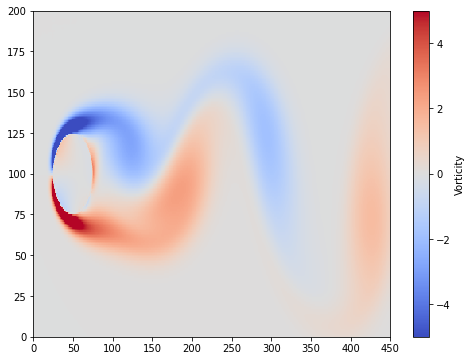

In [161]:
import matplotlib.pyplot as plt
koji=34

vort1=vort[:,koji]

vort1 = np.clip(vort1, -5,5)

fig, ax = plt.subplots(figsize=(8, 6))
y_os = np.linspace(0,200,200)
x_os = np.linspace(0,450,450)

c = ax.pcolormesh(x_os, y_os, vort1.reshape((-1,199)).T, cmap='coolwarm')
fig.colorbar(c, ax=ax, label='Vorticity')



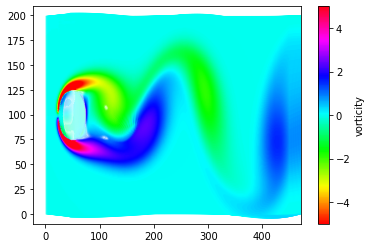

In [162]:
plt.figure()
x_os_2=np.repeat(x_os[:-1], 199); y_os_2=np.tile(y_os[:-1], 449)
q = plt.quiver(x_os_2, y_os_2, u[:,koji], v[:,koji], vort1, cmap='hsv', scale=10)
q.set_clim(-5, 5)
cb = plt.colorbar(q)
cb.set_label('vorticity')
plt.show()